# Environmental setup

In [7]:
# %load ~/python/my_import.py
# BASIC
import numpy as np
import xarray as xr
import pandas as pd

#xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays
import os
os.environ['HDF5_PLUGIN_PATH'] = '/work/bm0021/conda-envs/eerie_io/lib/python3.11/site-packages/hdf5plugin/plugins'

# matplotlib
import matplotlib
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.tri as mtri
import matplotlib.dates as md
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib import ticker
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['axes.linewidth'] = 1.5

## color
from matplotlib import cm
import cmocean
import seaborn as sns

## cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point


# scipy
from scipy import stats
from scipy import optimize
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from scipy.stats import binned_statistic
import scipy.spatial.qhull as qhull


# metpy
import metpy
import metpy.calc as mpcalc


# etc
import subprocess
import time
import datetime
from datetime import timedelta
import calendar


# Dask
import dask # Distributed data libary
from dask import delayed
from dask import compute
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from distributed import Client, progress # Libaray to orchestrate distributed resources
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

from pathlib import Path
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib.dates import DateFormatter

In [8]:
# Set some user specific variables
account_name = 'mh0731' # Account that is going to be 'charged' fore the computation
queue = 'compute' # Name of the partition we want to use
# queue = 'gpu' # Name of the partition we want to use
#queue = 'shared' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "500GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 16 # Max number of cores per task that are reserved - also partition dependend
walltime = '4:00:00' # Walltime - also partition dependent

scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':12435'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

cluster.scale(jobs=1)
cluster

dask_client = Client(cluster)
dask_client

<Client: 'tcp://136.172.120.74:35135' processes=0 threads=0, memory=0 B>

In [9]:
molC_to_g     = 12.01
molC_to_kg    = 12.01 * 1.e-3
molCO2_to_g   = 44.01
molCO2_to_gg  = 44.01 * 1.e-3
sec_per_day   = 86400.
days_per_year = 365.

to_gC_year = molC_to_g * sec_per_day * days_per_year
to_gC      = molC_to_g

# data

In [10]:
resolution = 'R2B9'

In [11]:
dpath = '/work/mh0731/m300793/Carbon/grid-generator/grids/'

if resolution == 'R2B4':
    gridICON = xr.open_mfdataset(f'{dpath}/icon_grid_0043_R02B04_EU.nc')
elif resolution == 'R2B6':
    gridICON = xr.open_mfdataset(f'{dpath}/icon_grid_0021_R02B06_EU.nc')
elif resolution == 'R2B9':
    gridICON = xr.open_mfdataset(f'{dpath}/icon_grid_0015_R02B09_EU.nc')
else:
    raise Exception("Select R2B4, R2B6, or R2B9")
    
gridICON

<xarray.Dataset>
Dimensions:                         (cell: 279900, nv: 3, vertex: 146946,
                                     edge: 428899, no: 4, nc: 2, ne: 6,
                                     max_chdom: 1, cell_grf: 14, edge_grf: 24,
                                     vert_grf: 13)
Coordinates:
    clon                            (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    clat                            (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    vlon                            (vertex) float64 dask.array<chunksize=(146946,), meta=np.ndarray>
    vlat                            (vertex) float64 dask.array<chunksize=(146946,), meta=np.ndarray>
    elon                            (edge) float64 dask.array<chunksize=(428899,), meta=np.ndarray>
    elat                            (edge) float64 dask.array<chunksize=(428899,), meta=np.ndarray>
Dimensions without coordinates: cell, nv, vertex, edge, no, nc, ne, max_chdom,
                                cell_grf, edge_grf, vert_grf
Data variables: (12/79)
    clon_vertices                   (cell, nv) float64 dask.array<chunksize=(279900, 3), meta=np.ndarray>
    clat_vertices                   (cell, nv) float64 dask.array<chunksize=(279900, 3), meta=np.ndarray>
    elon_vertices                   (edge, no) float64 dask.array<chunksize=(428899, 4), meta=np.ndarray>
    elat_vertices                   (edge, no) float64 dask.array<chunksize=(428899, 4), meta=np.ndarray>
    cell_area                       (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    dual_area                       (vertex) float64 dask.array<chunksize=(146946,), meta=np.ndarray>
    ...                              ...
    edge_dual_normal_cartesian_x    (edge) float64 dask.array<chunksize=(428899,), meta=np.ndarray>
    edge_dual_normal_cartesian_y    (edge) float64 dask.array<chunksize=(428899,), meta=np.ndarray>
    edge_dual_normal_cartesian_z    (edge) float64 dask.array<chunksize=(428899,), meta=np.ndarray>
    cell_circumcenter_cartesian_x   (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    cell_circumcenter_cartesian_y   (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    cell_circumcenter_cartesian_z   (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
Attributes: (12/34)
    title:                    ICON grid description
    institution:              Max Planck Institute for Meteorology/Deutscher ...
    source:                   git@gitlab.dkrz.de:mpim-sw/grid-generator.git
    revision:                 af7c06e8f469272b80158baabf60568c59888b9d
    history:                  /work/mh0731/m300793/Carbon/grid-generator/bin/...
    date:                     20240205 at 202058
    ...                       ...
    mean_cell_area:           24323517.809282698
    mean_dual_cell_area:      48647026.33989711
    domain_length:            40031612.44147649
    domain_height:            40031612.44147649
    sphere_radius:            6371229.0
    domain_cartesian_center:  [0. 0. 0.]

In [12]:
vlon, vlat = gridICON['vlon'].values*180./np.pi, gridICON['vlat'].values*180./np.pi
clon, clat = gridICON['clon'].values*180./np.pi, gridICON['clat'].values*180./np.pi
elements   = gridICON.vertex_of_cell[:,:].T.values-1

### Open function

In [13]:
def get_data_4yearly(grid, expname, dpath, start_year, end_year, time_init='2023-01-01', is_cold_start=True, ):
    
    dataICON_basic_list = []
    
    if (start_year == 2021) & (is_cold_start):
        dataICON_basic1 = xr.open_mfdataset(f'{dpath}/2021-????/*_jsbalone_{grid}_{expname}_lnd_basic_ml_*Z.nc_cflux')
        # dataICON_basic1 = xr.open_mfdataset(f'{dpath}/2021-????/*_jsbalone_{grid}_{expname}_lnd_basic_ml_*Z.nc')
        dataICON_basic1 = dataICON_basic1.isel(time=slice(1,-1)).mean('time')
        dataICON_basic_list.append(dataICON_basic1)
        start_year2 = start_year + 4
    else:
        start_year2 = start_year
        
    for yyyy in np.arange(start_year2, end_year+4, 4):
        dataICON_basic1 = xr.open_mfdataset(f'{dpath}/{yyyy}-????/*_jsbalone_{grid}_{expname}_lnd_basic_ml_*Z.nc_cflux')
        # dataICON_basic1 = xr.open_mfdataset(f'{dpath}/{yyyy}-????/*_jsbalone_{grid}_{expname}_lnd_basic_ml_*Z.nc')
        dataICON_basic1 = dataICON_basic1.isel(time=slice(0,-1)).mean('time')
        dataICON_basic_list.append(dataICON_basic1)
        
    dataICON_basic_output = xr.concat(dataICON_basic_list, xr.cftime_range(start=time_init, periods=len(dataICON_basic_list), freq="4Y", name='time'))

    return dataICON_basic_output

### Read data

In [14]:
if resolution == 'R2B4':
    id, grid, expname, is_cold_start = 'e44', resolution, 'germany', True
    start_year, end_year = 2021, 2417
elif resolution == 'R2B6':
    id, grid, expname, is_cold_start = 'e60', resolution, 'EU', False
    start_year, end_year = 2025, 2221
elif resolution == 'R2B9':
    id, grid, expname, is_cold_start = 't90', resolution, 'EU', False
    start_year, end_year = 2021, 2501

In [15]:
dpath = f'/work/mh0731/m300793/Carbon/1jsb-hr-std/experiments/{id}_jsbalone_{grid}_{expname}/'
# dpath = f'/work/mh0731/m300793/JSBACH/1jsb-hr-std/experiments/{id}_jsbalone_{grid}_{expname}/'

# dataICON_basic = get_data(grid, expname, dpath, start_year, end_year, time_init='2021-01-01', is_cold_start=is_cold_start)
dataICON_basic = get_data_4yearly(grid, expname, dpath, start_year, end_year, time_init='2023-01-02', is_cold_start=is_cold_start)
dataICON_basic

<xarray.Dataset>
Dimensions:                         (ncells: 279900, time: 121, vertices: 3,
                                     soil_depth_energy: 5, bnds: 2,
                                     soil_depth_water: 5)
Coordinates:
    clon                            (ncells) float32 0.01745 0.01844 ... 0.4093
    clat                            (ncells) float32 0.9182 0.9185 ... 0.8338
  * soil_depth_energy               (soil_depth_energy) float64 0.0325 ... 6.984
  * soil_depth_water                (soil_depth_water) float64 0.0325 ... 6.984
  * time                            (time) object 2023-12-31 00:00:00 ... 250...
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/20)
    clon_bnds                       (time, ncells, vertices) float32 dask.array<chunksize=(1, 279900, 3), meta=np.ndarray>
    clat_bnds                       (time, ncells, vertices) float32 dask.array<chunksize=(1, 279900, 3), meta=np.ndarray>
    soil_depth_energy_bnds          (time, soil_depth_energy, bnds) float64 dask.array<chunksize=(1, 5, 2), meta=np.ndarray>
    soil_depth_water_bnds           (time, soil_depth_water, bnds) float64 dask.array<chunksize=(1, 5, 2), meta=np.ndarray>
    sse_t_soil_sl_box               (time, soil_depth_energy, ncells) float32 dask.array<chunksize=(1, 5, 279900), meta=np.ndarray>
    hydro_wtr_soil_sl_box           (time, soil_depth_water, ncells) float32 dask.array<chunksize=(1, 5, 279900), meta=np.ndarray>
    ...                              ...
    carbon_c_sum_humus_ta_box       (time, ncells) float32 dask.array<chunksize=(1, 279900), meta=np.ndarray>
    carbon_c_sum_natural_ta_box     (time, ncells) float32 dask.array<chunksize=(1, 279900), meta=np.ndarray>
    carbon_soil_respiration_ta_box  (time, ncells) float32 dask.array<chunksize=(1, 279900), meta=np.ndarray>
    carbon_npp_pot_ydaymean_ta_box  (time, ncells) float32 dask.array<chunksize=(1, 279900), meta=np.ndarray>
    carbon_npp_act_ydaymean_ta_box  (time, ncells) float32 dask.array<chunksize=(1, 279900), meta=np.ndarray>
    carbon_gpp_ydaymean_ta_box      (time, ncells) float32 dask.array<chunksize=(1, 279900), meta=np.ndarray>

In [16]:
box2 = [-15, 0,     25, 35.910]
box3 = [  0, 11.64, 25, 37.40]

In [17]:
clon, clat = dataICON_basic['clon']*180./np.pi, dataICON_basic['clat']*180./np.pi
# dataICON_basic1 = dataICON_basic

# Carbon storage

In [18]:
carbon_storage = {}
carbon_stodiff = {}

var_list = ['sum_veg', 'sum_litter_ag', 'sum_litter_bg', 'sum_humus', 'sum_natural', 
            'green', 'woods', 'reserve', 'crop_harvest']
var_list = ['sum_humus', 'sum_natural',]

In [19]:
for variable in var_list:
    carbon_storage[f'{variable}'] = dataICON_basic[f'carbon_c_{variable}_ta_box'].compute() * to_gC
    # carbon_storage[f'{variable}'] = dataICON_basic[f'{variable}'].compute() * to_gC
    # carbon_stodiff[f'{variable}'] = carbon_storage[f'{variable}'].diff('time')/4.

In [20]:
total_ncells = carbon_storage[var_list[0]].shape[1]

In [ ]:
rmax, cmax = 5, 2
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(14, 20),)

for idx, variable in enumerate(var_list):
    rr, cc = idx % 5, int(idx/5)
    variable = var_list[idx]
    for ncells in np.arange(0, total_ncells, 1000):
        # carbon_storage[variable].isel(ncells=ncells).rolling(time=5).mean().plot(ax=ax[rr,cc])
        carbon_storage[variable].isel(ncells=ncells).plot(ax=ax[rr,cc], linewidth=0.1)

    ax[rr,cc].set_ylabel('Carbon pool $[g \ C \ m^{-2}]$')
    ax[rr,cc].set_title(variable, size=15)
    ax[rr,cc].grid()
    
ax[4,1].set_visible(False)
plt.tight_layout()

### Check whether flat or not

In [ ]:
rmax, cmax = 5, 2
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(14, 20),)

for idx, variable in enumerate(var_list):
    rr, cc = idx % 5, int(idx/5)
    variable = var_list[idx]
    # for ncells in np.arange(total_ncells):
    for ncells in np.arange(0, total_ncells, 1000):
        # x = carbon_storage[variable].isel(ncells=ncells).rolling(time=5).mean().diff('time')/4.
        x = carbon_storage[variable].isel(ncells=ncells).diff('time')/4.
        x.plot(ax=ax[rr,cc], linewidth=0.1)

    ax[rr,cc].set_ylim(-5, 100)
    ax[rr,cc].set_ylim(-3, 3)
    ax[rr,cc].set_ylabel('Carbon pool $[g \ C \ m^{-2} \ year^{-1}]$')
    ax[rr,cc].set_title(variable, size=15)
    ax[rr,cc].grid()
    
ax[4,1].set_visible(False)
plt.tight_layout()

In [ ]:
rmax, cmax = 5, 2
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(14, 20),)

total_ncells = carbon_storage[var_list[0]].shape[1]
for idx, variable in enumerate(var_list):
    rr, cc = idx % 5, int(idx/5)
    variable = var_list[idx]
    # count = xr.where(carbon_storage[variable].rolling(time=5).mean().diff('time')>=1, 1, 0) / total_ncells * 100
    count = xr.where(carbon_storage[variable].diff('time')/4 >=1, 1, 0) / total_ncells * 100
    count.sum('ncells').plot(ax=ax[rr,cc])

    ax[rr,cc].set_ylabel('Percentage of non-equilibrated $[\%]$')
    ax[rr,cc].set_title(variable, size=15)
    ax[rr,cc].grid()
    
ax[4,1].set_visible(False)
plt.tight_layout()

In [48]:
variable = 'sum_natural'
count = xr.where(carbon_storage[variable].rolling(time=5).mean().rolling(time=5).mean().rolling(time=5).mean().diff('time')/4.>=1, 1, 0)
count['time'].where( count.sum('ncells')==0)

<xarray.DataArray 'time' (time: 120)>
array([cftime.DatetimeGregorian(2027, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2031, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2035, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2039, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2043, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2047, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2051, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2055, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2059, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2063, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2067, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2071, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       cftime.DatetimeGregorian(2491, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2495, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2499, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2503, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 2027-12-31 00:00:00 ... 2503-12-31 00:00:00

- 2489~2492 shows first equilibrium.
- To be on the safe side, until 2493~2496 are in spin-up
- I can think 2497~2500 as real analysis year.

In [46]:
x  = carbon_storage[variable].rolling(time=5).mean().rolling(time=5).mean().rolling(time=5).mean().diff('time')/4.
# x = carbon_storage[variable].diff('time')/4.
z = xr.where(x>=1, 1, 0)
# z = xr.where(carbon_storage[variable].rolling(time=5).mean().rolling(time=5).mean().diff('time')/4.>=1, 1, 0)
y = x.values[:,(z.isel(time=-1).values == 1)]

# Plot time series

In [53]:
2496-2023

473

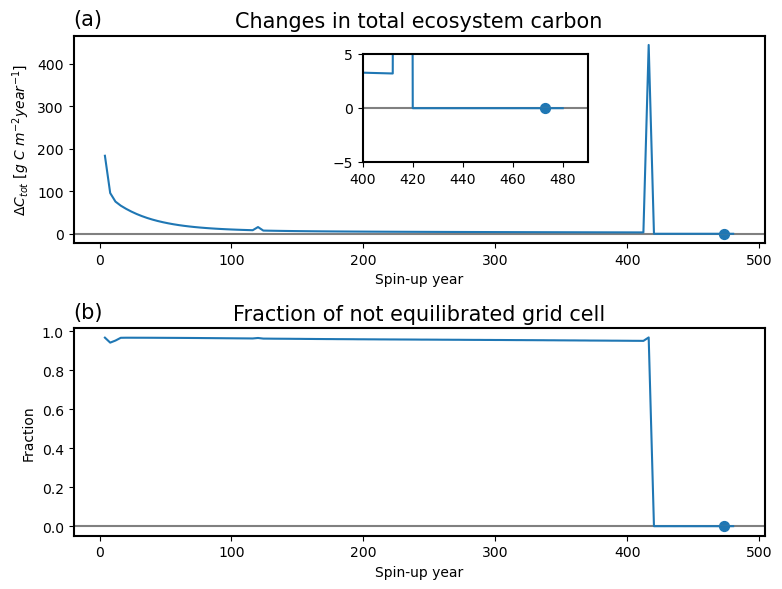

In [60]:
txt_x, txt_y = 0.0, 1.05
rmax, cmax = 2, 2
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(15, 6),)

rr, cc = 0, 0
ax[rr,cc].axhline(y=0, c='gray')
variable = 'sum_natural'
# variable       = f'carbon_c_{variable_short}_ta_box'

y9 = carbon_storage[variable].diff('time')/4.
y9 = y9.mean('ncells')
x9 = np.arange(y9['time'].values[0].year, y9['time'].values[-1].year+4, 4)-2022.9
ax[rr,cc].plot(x9, y9, c='C0', label='CONVENTIONAL_5km')
ax[rr,cc].scatter(473, 0, s=50, c='C0')

ax[rr,cc].set_xlabel('Spin-up year')
ax[rr,cc].set_ylabel('$\Delta C_{tot}$ $[g \ C \ m^{-2} year^{-1}]$')
ax[rr,cc].text(txt_x, txt_y, '(a)', transform=ax[rr,cc].transAxes, size=15)
ax[rr,cc].set_title('Changes in total ecosystem carbon', size=15)

left, bottom, width, height = [0.245, 0.72, 0.15, 0.18]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.axhline(y=0, c='gray')
ax2.plot(x9, y9, c='C0', label='CONVENTIONAL_5km')
ax2.scatter(473, y9.sel(time='2495').values, s=50, c='C0')
ax2.set_ylim(-5, 5)
ax2.set_xlim(400, 490)
ax2.set_xlabel(' ')


rr, cc = 1, 0
ax[rr,cc].axhline(y=0, c='gray')
variable = 'sum_natural'
count9 = xr.where(carbon_storage[variable].diff('time')/4 >=1, 1, 0) / carbon_storage[variable].shape[1]
y9 = count9.sum('ncells')
ax[rr,cc].plot(x9, y9, c='C0', label='CONVENTIONAL_5km')
ax[rr,cc].scatter(473, 0, s=50, c='C0')

ax[rr,cc].set_xlabel('Spin-up year')
ax[rr,cc].set_ylabel('Fraction')
ax[rr,cc].text(txt_x, txt_y, '(b)', transform=ax[rr,cc].transAxes, size=15)
ax[rr,cc].set_title('Fraction of not equilibrated grid cell', size=15)
# leg=ax[rr,cc].legend(prop={'size': 10})

# left, bottom, width, height = [0.245, 0.22, 0.15, 0.18]
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.axhline(y=0, c='gray')
# ax2.plot(x9, y9, c='C0', label='CONVENTIONAL_5km')
# ax2.scatter(473, y9.sel(time='2495').values, s=50, c='C0')
# ax2.set_ylim(-0.001, 0.001)
# ax2.set_xlim(400, 490)
# ax2.set_xlabel(' ')

rr, cc = 0, 1
ax[rr,cc].set_visible(False)
rr, cc = 1, 1
ax[rr,cc].set_visible(False)
plt.tight_layout()